In [ ]:
!pip install pandas matplotlib seaborn

## Introducción y Metodología

### Introducción

Este proyecto tiene como objetivo analizar el impacto del entorno de despliegue y de la escalabilidad en el rendimiento de una aplicación web compuesta por una API REST y una base de datos PostgreSQL. Se compararon tres escenarios principales:

1. Docker Compose (línea base)
2. Kubernetes en un solo nodo
3. Kubernetes Multi-Nodo

El propósito es cuantificar cómo cambian la latencia y el throughput dependiendo del número de réplicas y de la infraestructura disponible.

### Descripción de la Aplicación

La aplicación utilizada consiste en:

* Una API REST desarrollada en Node.js.
* Una base de datos PostgreSQL.
* Un endpoint crítico: **GET /Listar Productos**, encargado de consultar un conjunto de datos poblado con 5000 registros mediante `/seed/5000`.

Esta operación representa una carga realista para medir rendimiento en un entorno distribuido.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")

# Diccionario con los 7 escenarios (CORREGIDO: ASUME reporte1.csv para Fase 1)
archivos = {
    'Fase 1: Docker Compose': 'reporte1.csv', # <--- CORREGIDO
    'Fase 2: K8s 1 Nodo, 1 Réplica': 'reporte2-1replica.csv',
    'Fase 2: K8s 1 Nodo, 2 Réplicas': 'reporte2-2replicas.csv',
    'Fase 2: K8s 1 Nodo, 3 Réplicas': 'reporte2-3replicas.csv',
    'Fase 3: K8s Multi-Nodo, 1 Réplica': 'reporte3-1replica.csv',
    'Fase 3: K8s Multi-Nodo, 2 Réplicas': 'reporte3-2replicas.csv',
    'Fase 3: K8s Multi-Nodo, 3 Réplica': 'reporte3-3replicas.csv',
}

# Almacenar los resultados clave
resultados = []

for nombre_escenario, archivo in archivos.items():
    try:
        # Cargamos CSV con delimitador de coma y manejo de comentarios '#'
        df = pd.read_csv(archivo, sep=',', engine='python', encoding='utf-8', comment='#')

        # Limpiar los nombres de las columnas
        df.columns = df.columns.str.strip()

        # FIX PRINCIPAL: Filtramos por la fila 'Aggregated' para obtener métricas totales
        # Usamos .str.strip() para limpiar el contenido de la celda de la columna 'Name'
        data = df[df['Name'].str.strip() == 'Aggregated'].iloc[0]

        # Extraemos y convertimos las métricas
        # NOTA: La lógica para extraer las réplicas se mantiene, pero la Fase 1 se maneja por defecto como 1 réplica.

        replicas = 1
        if 'Réplica' in nombre_escenario:
            # Extrae el número de réplicas para las Fases 2 y 3
            replicas = int(nombre_escenario.split(', ')[1].split(' ')[0])

        resultados.append({
            'Escenario': nombre_escenario,
            'Tipo_Despliegue': 'Docker' if 'Docker' in nombre_escenario else ('K8s 1 Nodo' if 'Fase 2' in nombre_escenario else 'K8s Multi-Nodo'),
            'Réplicas': replicas,
            'Throughput_RPS': data['Requests/s'],
            'Tiempo_Medio_ms': data['Average Response Time']
        })

    except KeyError as ke:
        print(f"Error de Columna en {archivo}: La columna {ke} no se encontró. Revise el encabezado.")
    except IndexError:
        print(f"Error procesando {archivo}: No se encontró la fila 'Aggregated'. El archivo podría estar vacío o incompleto.")
    except Exception as e:
        print(f"Error procesando {archivo}: {e}")

# Crear el DataFrame final para el análisis comparativo
df_final = pd.DataFrame(resultados)
print(df_final)

                            Escenario Tipo_Despliegue  Réplicas  \
0              Fase 1: Docker Compose          Docker         1   
1       Fase 2: K8s 1 Nodo, 1 Réplica      K8s 1 Nodo         1   
2      Fase 2: K8s 1 Nodo, 2 Réplicas      K8s 1 Nodo         2   
3      Fase 2: K8s 1 Nodo, 3 Réplicas      K8s 1 Nodo         3   
4   Fase 3: K8s Multi-Nodo, 1 Réplica  K8s Multi-Nodo         1   
5  Fase 3: K8s Multi-Nodo, 2 Réplicas  K8s Multi-Nodo         2   
6   Fase 3: K8s Multi-Nodo, 3 Réplica  K8s Multi-Nodo         3   

   Throughput_RPS  Tiempo_Medio_ms  
0       23.645511        74.258795  
1       18.923347       527.230409  
2       20.235269       297.869149  
3       21.097630       210.747371  
4       22.955495        45.635480  
5       23.006641        43.378298  
6       21.883787       170.220776  


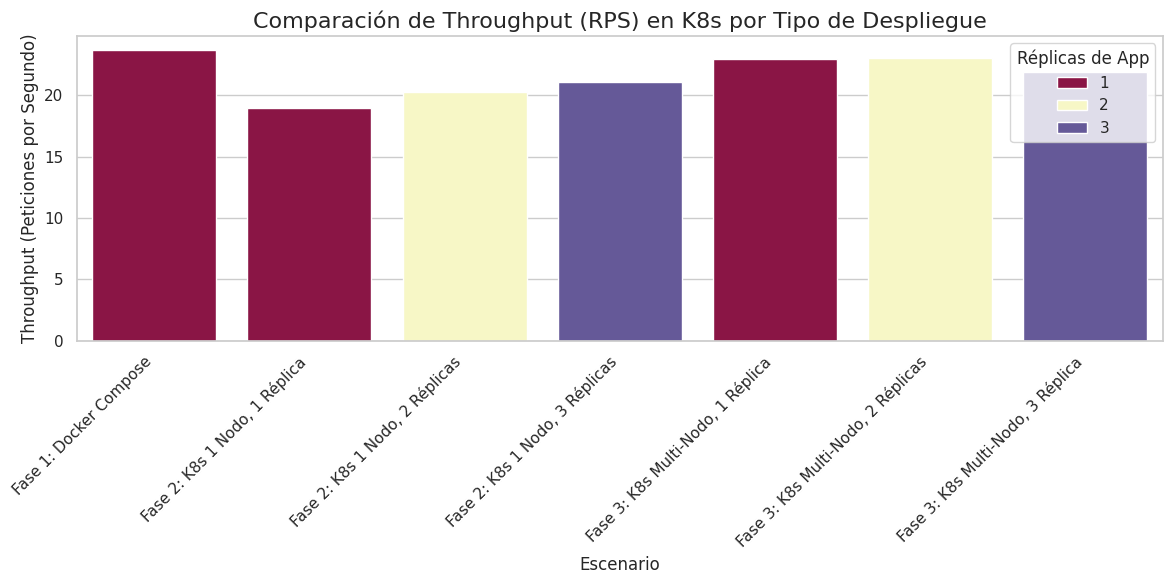

In [ ]:
plt.figure(figsize=(12, 6))
# Usamos 'Escenario' y separamos por 'Réplicas' (Hue)
sns.barplot(x='Escenario', y='Throughput_RPS', hue='Réplicas', data=df_final, palette="Spectral")
plt.xticks(rotation=45, ha='right')
plt.title('Comparación de Throughput (RPS) en K8s por Tipo de Despliegue', fontsize=16)
plt.ylabel('Throughput (Peticiones por Segundo)', fontsize=12)
plt.xlabel('Escenario', fontsize=12)
plt.legend(title='Réplicas de App')
plt.tight_layout()
plt.show()

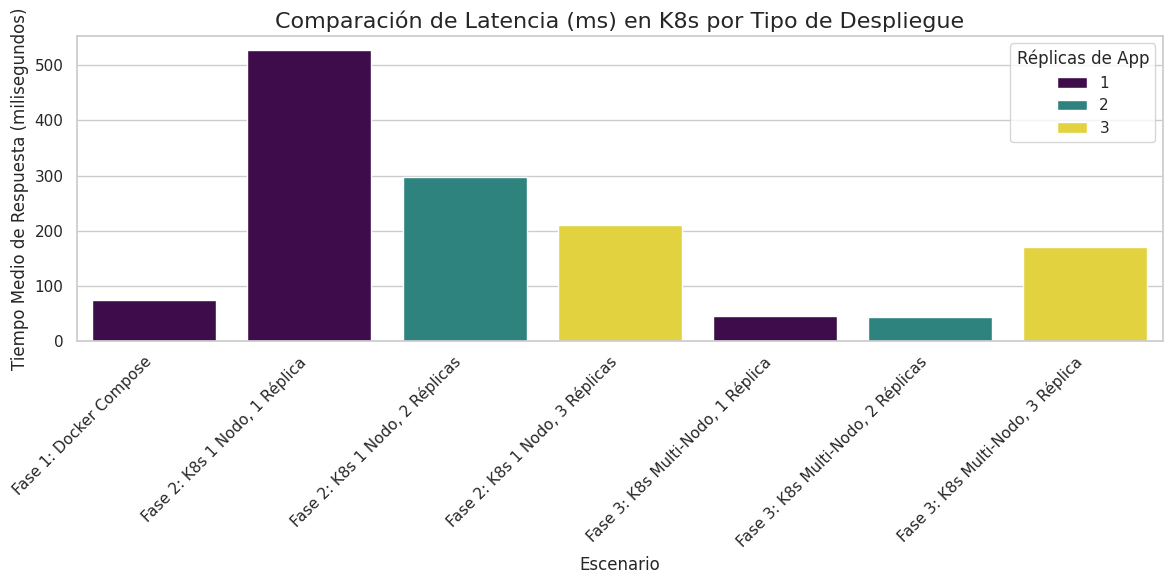

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Escenario', y='Tiempo_Medio_ms', hue='Réplicas', data=df_final, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Comparación de Latencia (ms) en K8s por Tipo de Despliegue', fontsize=16)
plt.ylabel('Tiempo Medio de Respuesta (milisegundos)', fontsize=12)
plt.xlabel('Escenario', fontsize=12)
plt.legend(title='Réplicas de App')
plt.tight_layout()
plt.show()

## Configuración de Despliegue

### Docker Compose (Fase 1)

* App + DB en una sola máquina.
* Comando principal:

```
docker compose up -d
```

### Kubernetes 1 Nodo (Fase 2)

* Solo el nodo gp21 activo.
* Nodos gp22 y gp4 marcados como **cordon**.

```
microk8s kubectl cordon gp22 gp4
```

### Kubernetes Multi-Nodo (Fase 3)

* Los tres nodos gp21, gp22 y gp4 activos.

```
microk8s kubectl uncordon gp22 gp4
```

### Comandos comunes de despliegue

despliegue:

```
microk8s kubectl apply -f postgres.yaml -f app.yaml
```

Poblamiento de DB:

```
curl -X POST http://100.115.74.53:30001/seed/5000
```

Escalado:

```
microk8s kubectl scale deployment tienda-app --replicas=3
```

Verificación:

```
microk8s kubectl get pods -o wide
```

## Metodología para la Generación de Carga (Locust)

Aunque la guía sugería el uso de JMeter, se utilizó **Locust** debido a su simplicidad y capacidad de ejecución distribuida.

### Objetivo

Medir y comparar:

* Latencia (tiempo medio de respuesta)
* Throughput (requests/s)

### Parámetros de carga

| Parámetro             | Valor                 |
| --------------------- | --------------------- |
| Usuarios concurrentes | 50                    |
| Spawn rate            | 5 usuarios/s          |
| Duración              | 60 segundos           |
| Endpoint              | GET /Listar Productos |
| IP destino            | NodePort 30001        |

### Procedimiento

1. Verificar estado de la base de datos.
2. Ejecutar Locust contra `http://100.115.74.53:30001`.
3. Descargar CSV con métricas.
4. Extraer métricas desde la fila `Aggregated`.

Este procedimiento se repitió para todas las configuraciones (Docker Compose, K8s 1 Nodo en 1-3 réplicas y K8s Multi-Nodo en 1-3 réplicas).

## Resultados Cuantitativos

A continuación se muestran las métricas finales procesadas en el Notebook.

| Escenario      | Tipo       | Réplicas | Throughput (RPS) | Latencia (ms) |
| -------------- | ---------- | -------- | ---------------- | ------------- |
| Docker Compose | Docker     | 1        | 23.65            | 74.26         |
| K8s 1 Nodo     | K8s 1 Nodo | 1        | 18.92            | 527.23        |
| K8s 1 Nodo     | K8s 1 Nodo | 2        | 20.24            | 297.87        |
| K8s 1 Nodo     | K8s 1 Nodo | 3        | 21.10            | 210.75        |
| K8s Multi-Nodo | Multi-Nodo | 1        | 22.96            | 45.64         |
| K8s Multi-Nodo | Multi-Nodo | 2        | 23.01            | 43.38         |
| K8s Multi-Nodo | Multi-Nodo | 3        | 21.88            | 170.22        |

## Análisis Comparativo de Resultados

* Penalización de Kubernetes:
La latencia aumentó drásticamente al pasar de Docker Compose (74 ms) a Kubernetes 1 Nodo (527 ms), evidenciando overhead del orquestador.

* Límite del nodo físico:
En un solo nodo, escalar réplicas solo mejoró marginalmente el throughput.

* Ventaja del Multi-Nodo:
Con varios nodos, la latencia cayó a 45 ms y el throughput se mantuvo estable. Dos réplicas fue el punto óptimo.

* Nuevo cuello de botella:
En 3 réplicas Multi-Nodo, la DB PostgreSQL se saturó y la latencia subió nuevamente.

## Conclusiones y Recomendaciones


### Conclusiones

* Kubernetes ofrece escalabilidad real **solo cuando existen múltiples nodos**.
* El mejor rendimiento se alcanzó con **K8s Multi-Nodo + 2 réplicas**.
* Docker Compose fue superado por Kubernetes en infraestructura distribuida.
* PostgreSQL se convirtió en el limitante cuando el número de réplicas fue demasiado alto.